In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a0ef21c01af59659eef46363cc73610ce6564e9a5ee5e8597b856cefcc860c0f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import lime
import lime.lime_tabular
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import average_precision_score, roc_auc_score, classification_report, make_scorer
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# Import data

In [ ]:
data = pd.read_csv('credit_card_prediction_cleaned_3.csv')

In [ ]:
data.columns

Index(['gender', 'owns_car', 'owns_property', 'n_children', 'annual_income',
       'income_type', 'education_type', 'marital_status', 'housing_type',
       'has_email', 'occupation', 'n_fam_members', 'age', 'label',
       'employment_age_ratio', 'single_parent', 'communication_score'],
      dtype='object')

In [ ]:
numerical_features = ['n_children', 'annual_income','n_fam_members', 'age', 'employment_age_ratio',  'communication_score']

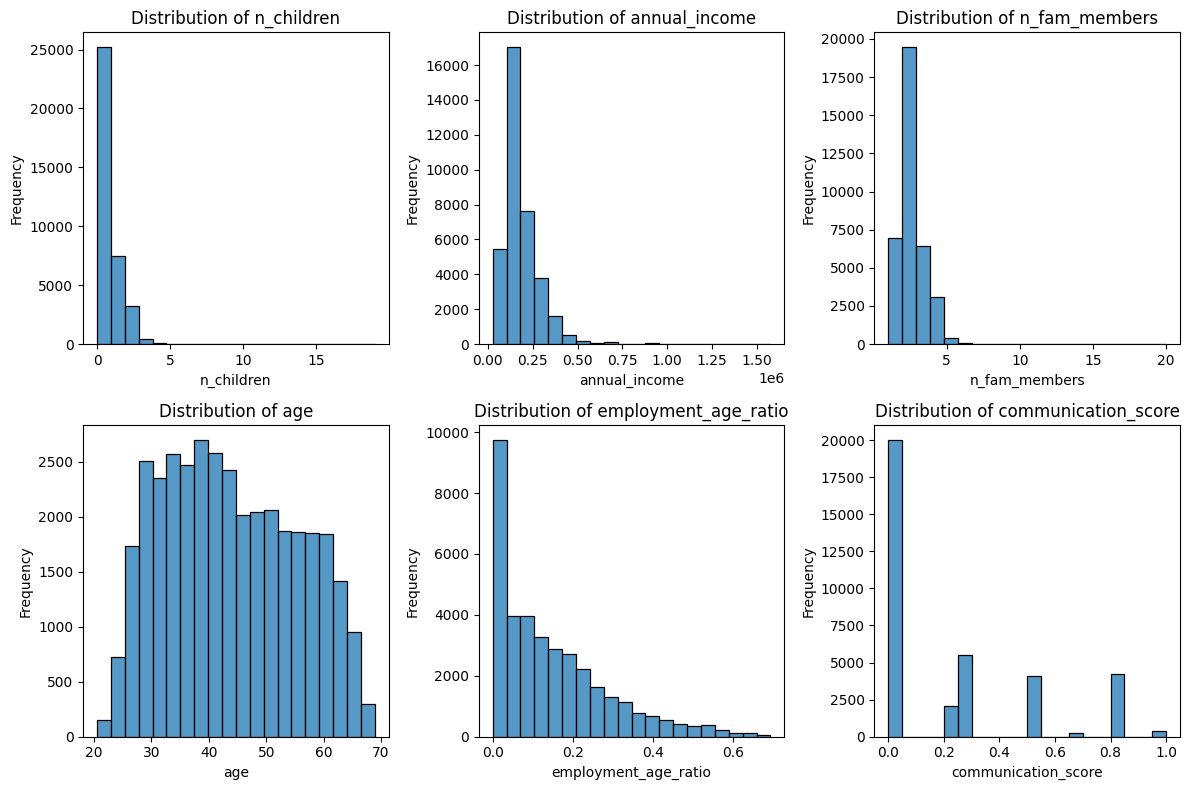

In [ ]:
# draw histogram for all numerical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(data[numerical_features].columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], bins=20)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [ ]:
for feature in numerical_features:
    if feature != 'age':
        # Create new column name
        log_feature = 'log_' + feature

        # Copy original data to new column
        data[log_feature] = data[feature].copy()

        # Apply offset if needed
        min_val = data[feature].min()
        if min_val <= 0:
            offset = abs(min_val) + 1
            data[log_feature] = data[log_feature] + offset

        # Apply log transformation
        data[log_feature] = np.log1p(data[log_feature])

data.head()

,gender,owns_car,owns_property,n_children,annual_income,income_type,education_type,marital_status,housing_type,has_email,...,age,label,employment_age_ratio,single_parent,communication_score,log_n_children,log_annual_income,log_n_fam_members,log_employment_age_ratio,log_communication_score
0,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,0,...,32.890411,1,0.378342,0,0.5,0.693147,12.965712,1.098612,0.866404,0.916291
1,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,0,...,32.890411,1,0.378342,0,0.5,0.693147,12.965712,1.098612,0.866404,0.916291
2,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,...,58.832877,1,0.052808,0,0.0,0.693147,11.630717,1.098612,0.719209,0.693147
3,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,...,52.356164,1,0.159655,0,0.5,0.693147,12.506181,0.693147,0.769948,0.916291
4,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,...,52.356164,1,0.159655,0,0.5,0.693147,12.506181,0.693147,0.769948,0.916291


In [ ]:
log_features = ['log_n_children', 'log_annual_income', 'log_n_fam_members', 'log_employment_age_ratio', 'log_communication_score']

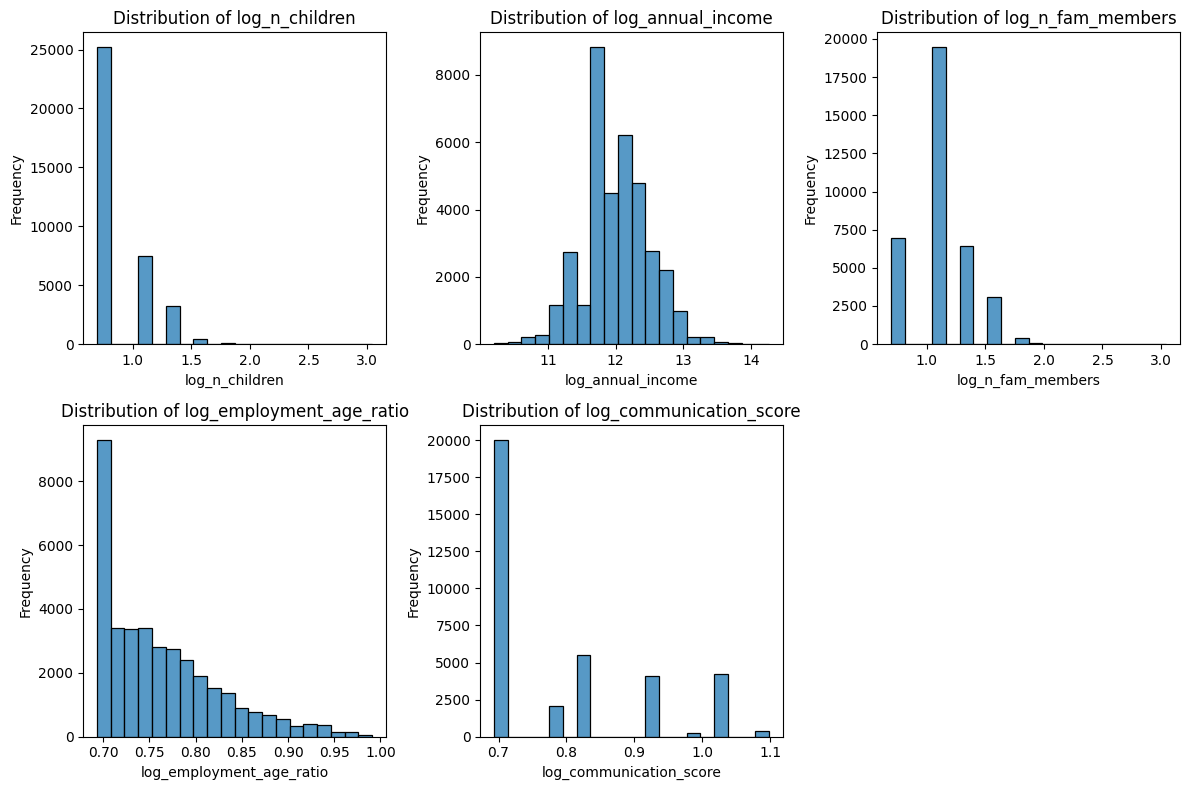

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(data[log_features].columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], bins=20)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Model Training

In [ ]:
data.columns

Index(['gender', 'owns_car', 'owns_property', 'n_children', 'annual_income',
       'income_type', 'education_type', 'marital_status', 'housing_type',
       'has_email', 'occupation', 'n_fam_members', 'age', 'label',
       'employment_age_ratio', 'single_parent', 'communication_score',
       'log_n_children', 'log_annual_income', 'log_n_fam_members',
       'log_employment_age_ratio', 'log_communication_score'],
      dtype='object')

In [ ]:
# Separate features and target
X = data.drop(columns=['label'], axis=1)
y = data['label']

In [ ]:
X.columns

Index(['gender', 'owns_car', 'owns_property', 'n_children', 'annual_income',
       'income_type', 'education_type', 'marital_status', 'housing_type',
       'has_email', 'occupation', 'n_fam_members', 'age',
       'employment_age_ratio', 'single_parent', 'communication_score',
       'log_n_children', 'log_annual_income', 'log_n_fam_members',
       'log_employment_age_ratio', 'log_communication_score'],
      dtype='object')

In [ ]:
numerical_features = [ 'log_n_children', 'log_annual_income','log_n_fam_members', 'age',
                      'employment_age_ratio', 'communication_score']
categorical_features = ['gender', 'owns_car', 'owns_property',
       'income_type', 'education_type', 'marital_status', 'housing_type', 'has_email', 'occupation', 'single_parent']

In [ ]:
# Split the data into training and testing sets (First)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create preprocessing transformers
numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the training data
X_train = preprocessor.fit_transform(X_train)
# Transform the test data using the same preprocessor
X_test = preprocessor.transform(X_test)

In [ ]:
sampler = SMOTE(random_state=42)
X_train, y_train = sampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - SMOTE Data Metrics:
--------------------------------------------------
Precision: 0.9975
Recall: 0.6643
F1 Score: 0.7975
PRC AUC Score: 0.9958
ROC AUC Score: 0.6172
Matthews Correlation Coefficient: 0.0334

Confusion Matrix:
--------------------------------------------------


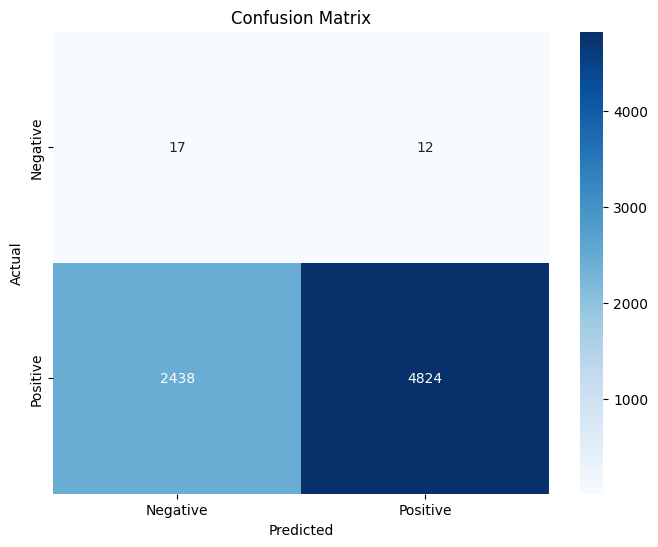


Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.01      0.59      0.01        29
           1       1.00      0.66      0.80      7262

    accuracy                           0.66      7291
   macro avg       0.50      0.63      0.41      7291
weighted avg       0.99      0.66      0.79      7291



In [ ]:
# Train logistic regression on SMOTE data
lr_smote = LogisticRegression(random_state=42)
lr_smote.fit(X_train, y_train)

# Make predictions
y_pred_original = lr_smote.predict(X_test)
y_prob_original = lr_smote.predict_proba(X_test)[:, 1]

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred_original)
precision = precision_score(y_test, y_pred_original)
recall = recall_score(y_test, y_pred_original)
f1 = f1_score(y_test, y_pred_original)
prc_auc = average_precision_score(y_test, y_prob_original)
roc_auc = roc_auc_score(y_test, y_prob_original)
mcc = matthews_corrcoef(y_test, y_pred_original)

# Print metrics
print("Logistic Regression - SMOTE Data Metrics:")
print("-" * 50)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PRC AUC Score: {prc_auc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print("\nConfusion Matrix:")
print("-" * 50)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("\nDetailed Classification Report:")
print("-" * 50)
print(classification_report(y_test, y_pred_original))

# Threshold Tuning

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
 [[  17   12]
 [2185 5077]]
Precision: 0.9976419728826882
Recall: 0.6991187000826219
F1 Score: 0.8221196664237713
PRC AUC: 0.9958023435086885
ROC AUC: 0.6171853483888736
Matthews Correlation Coefficient: 0.03911496739431187


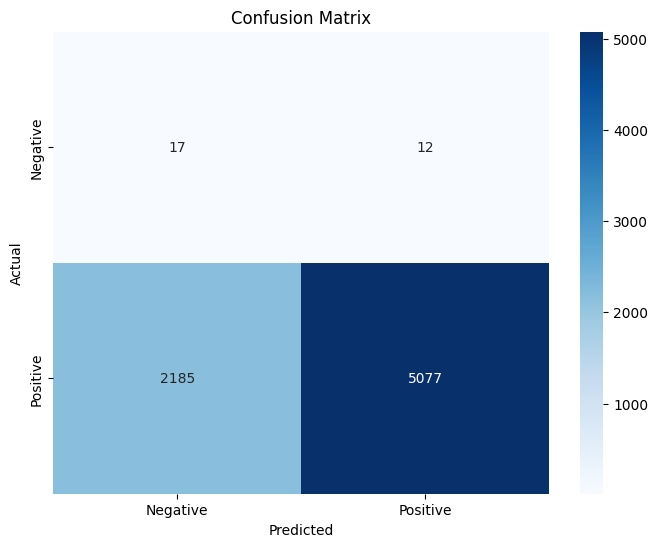


Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.01      0.59      0.02        29
           1       1.00      0.70      0.82      7262

    accuracy                           0.70      7291
   macro avg       0.50      0.64      0.42      7291
weighted avg       0.99      0.70      0.82      7291



In [ ]:
# Train logistic regression on SMOTE data
lr_smote = LogisticRegression()
lr_smote.fit(X_train, y_train)

# Set a custom threshold
threshold = 0.48  # Adjust this value as needed

# Make predictions with custom threshold
y_pred_custom = (y_prob_original >= threshold).astype(int)

# Calculate metrics with custom threshold
conf_matrix_custom = confusion_matrix(y_test, y_pred_custom)
precision_custom = precision_score(y_test, y_pred_custom)
recall_custom = recall_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom)
prc_auc_custom = average_precision_score(y_test, y_prob_original)
roc_auc_custom = roc_auc_score(y_test, y_prob_original)
mcc_custom = matthews_corrcoef(y_test, y_pred_custom)

# Display metrics
print("Confusion Matrix:\n", conf_matrix_custom)
print("Precision:", precision_custom)
print("Recall:", recall_custom)
print("F1 Score:", f1_custom)
print("PRC AUC:", prc_auc_custom)
print("ROC AUC:", roc_auc_custom)
print("Matthews Correlation Coefficient:", mcc_custom)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("\nDetailed Classification Report:")
print("-" * 50)
print(classification_report(y_test, y_pred_custom))

# Hyperparameter Tuning

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Hyperparameters:
{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 10}

Logistic Regression - Tuned SMOTE Data Metrics:
--------------------------------------------------
Precision: 0.9973
Recall: 0.6665
F1 Score: 0.7990
PRC AUC Score: 0.9957
ROC AUC Score: 0.6144
Matthews Correlation Coefficient: 0.0291


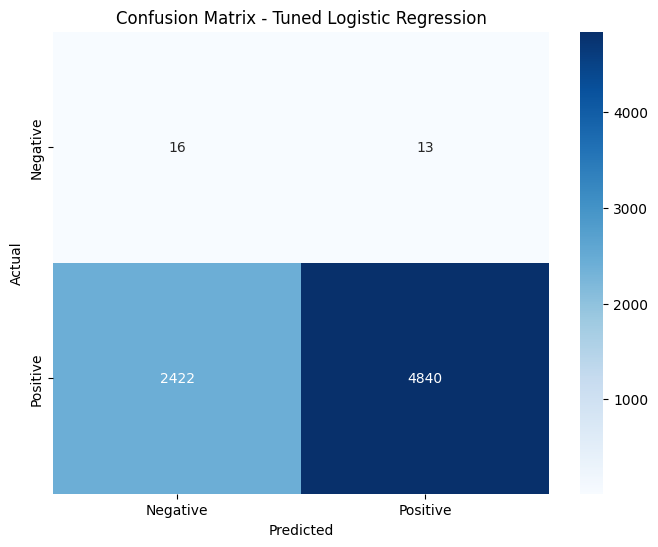


Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.01      0.55      0.01        29
           1       1.00      0.67      0.80      7262

    accuracy                           0.67      7291
   macro avg       0.50      0.61      0.41      7291
weighted avg       0.99      0.67      0.80      7291



In [ ]:
from tqdm import tqdm

# Simplified parameter distribution with fewer options
param_distributions = {
    'C': [0.1, 1, 10],
    'penalty': ['l1'],
    'solver': ['liblinear'],
    'max_iter': [100]
}

# Custom scorer that emphasizes true negatives
def tn_scorer(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Create custom scorer
tn_custom_scorer = make_scorer(tn_scorer)

# Create the base Logistic Regression model
lr = LogisticRegression(random_state=42)

# Reduced RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring=tn_custom_scorer,
    n_jobs=1,
    random_state=42
)

# Fit RandomizedSearchCV on the SMOTE-transformed data
random_search.fit(X_train, y_train)

# Best model and its parameters
best_lr = random_search.best_estimator_
best_params = random_search.best_params_

# Predictions using the best model
y_pred = best_lr.predict(X_test)
y_prob = best_lr.predict_proba(X_test)[:, 1]

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
prc_auc = average_precision_score(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
mcc = matthews_corrcoef(y_test, y_pred)

# Print best parameters
print("Best Hyperparameters:")
print(best_params)

# Print metrics
print("\nLogistic Regression - Tuned SMOTE Data Metrics:")
print("-" * 50)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PRC AUC Score: {prc_auc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Tuned Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("\nDetailed Classification Report:")
print("-" * 50)
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[  17   12]
 [2185 5077]]
Precision: 0.9976419728826882
Recall: 0.6991187000826219
F1 Score: 0.8221196664237713
PRC AUC: 0.9958023435086885
ROC AUC: 0.6171853483888736
Matthews Correlation Coefficient: 0.03911496739431187


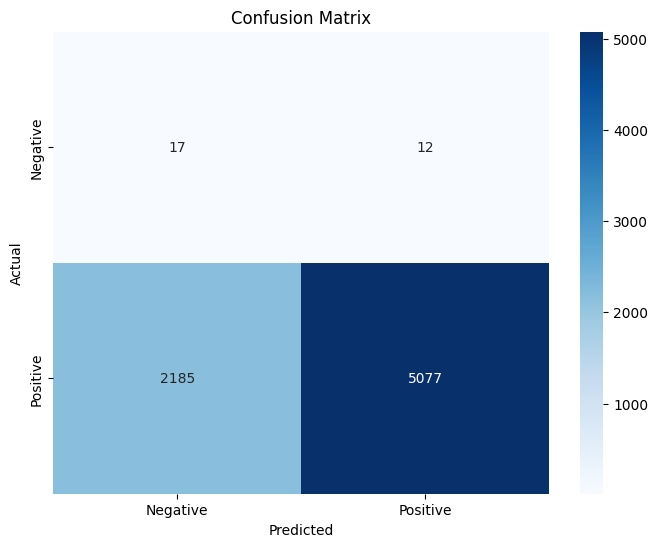


Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.01      0.59      0.02        29
           1       1.00      0.70      0.82      7262

    accuracy                           0.70      7291
   macro avg       0.50      0.64      0.42      7291
weighted avg       0.99      0.70      0.82      7291



In [ ]:
# Train logistic regression on SMOTE data
lr_smote = LogisticRegression(solver='liblinear', penalty='l1', max_iter=100, C=10)
lr_smote.fit(X_train, y_train)

# Set a custom threshold
threshold = 0.48  # Adjust this value as needed

# Make predictions with custom threshold
y_pred_custom = (y_prob_original >= threshold).astype(int)

# Calculate metrics with custom threshold
conf_matrix_custom = confusion_matrix(y_test, y_pred_custom)
precision_custom = precision_score(y_test, y_pred_custom)
recall_custom = recall_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom)
prc_auc_custom = average_precision_score(y_test, y_prob_original)
roc_auc_custom = roc_auc_score(y_test, y_prob_original)
mcc_custom = matthews_corrcoef(y_test, y_pred_custom)

# Display metrics
print("Confusion Matrix:\n", conf_matrix_custom)
print("Precision:", precision_custom)
print("Recall:", recall_custom)
print("F1 Score:", f1_custom)
print("PRC AUC:", prc_auc_custom)
print("ROC AUC:", roc_auc_custom)
print("Matthews Correlation Coefficient:", mcc_custom)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("\nDetailed Classification Report:")
print("-" * 50)
print(classification_report(y_test, y_pred_custom))

# Features Importance

Feature Importance Analysis:
                                     Feature  Importance  Coefficient
                       occupation_unemployed   12.661415    12.661415
                          occupation_retired   12.221153    12.221153
                       income_type_Pensioner   11.151609   -11.151609
               housing_type_Rented apartment    8.733651     8.733651
            occupation_Private service staff    8.070819     8.070819
             occupation_Waiters/barmen staff    7.526169     7.526169
                      occupation_Secretaries    6.730235     6.730235
                         occupation_HR staff    6.679929     6.679929
                    occupation_Realty agents    6.628925     6.628925
                         income_type_Student    3.886395     3.886395
                         occupation_IT staff    3.613380    -3.613380
             education_type_Higher education    3.606308    -3.606308
education_type_Secondary / secondary special    3.529227    -

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'occupation'),
  Text(1, 0, 'income_type'),
  Text(2, 0, 'education_type'),
  Text(3, 0, 'housing_type'),
  Text(4, 0, 'marital_status'),
  Text(5, 0, 'log_n_children'),
  Text(6, 0, 'log_n_fam_members'),
  Text(7, 0, 'gender'),
  Text(8, 0, 'single_parent'),
  Text(9, 0, 'employment_age_ratio'),
  Text(10, 0, 'has_email'),
  Text(11, 0, 'age'),
  Text(12, 0, 'owns_car'),
  Text(13, 0, 'log_annual_income'),
  Text(14, 0, 'communication_score'),
  Text(15, 0, 'owns_property')])

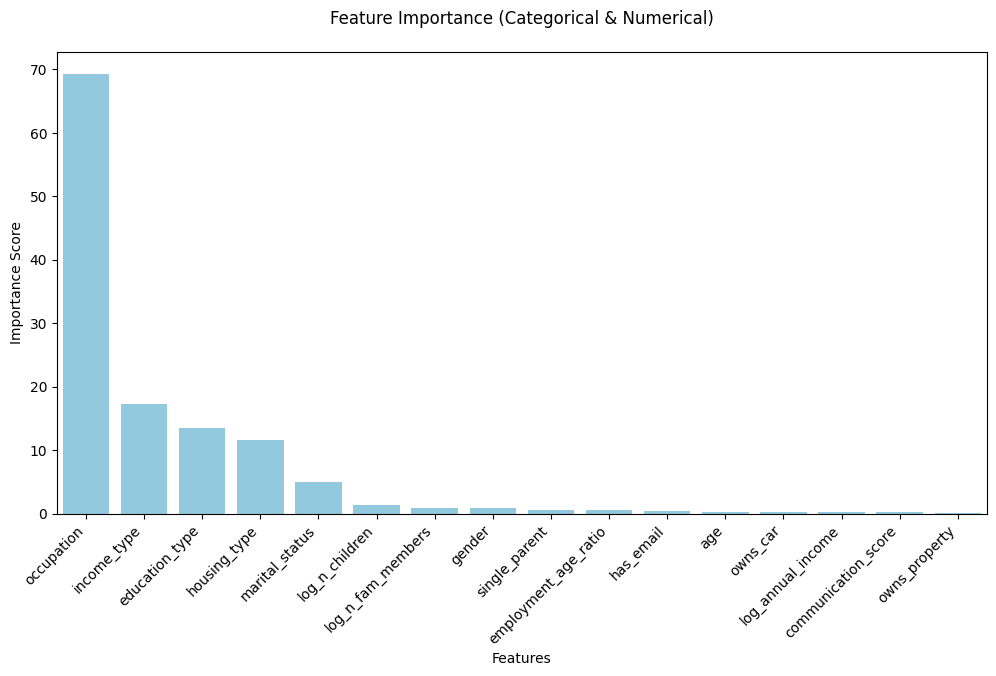

In [ ]:
# Get feature names from preprocessor
def get_feature_names(preprocessor, numerical_features, categorical_features):
    feature_names = []

    # Get numerical feature names (unchanged)
    feature_names.extend(numerical_features)

    # Get categorical feature names (with one-hot encoding)
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names.extend(cat_feature_names)

    return feature_names

# Get all feature names after transformation
feature_names = get_feature_names(preprocessor, numerical_features, categorical_features)

# Get coefficients
coefficients = lr_smote.coef_[0]
importance = np.abs(coefficients)

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance,
    'Coefficient': coefficients
})

# Sort by absolute importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Print detailed feature importance
print("Feature Importance Analysis:")
print("============================")
print(feature_importance.to_string(index=False))

# Dictionary to store categorical feature importance
category_importance = {}

# Sum importance for categorical features
for category in categorical_features:
    category_mask = feature_importance['Feature'].str.startswith(category + '_')
    category_sum = feature_importance.loc[category_mask, 'Importance'].sum()
    category_importance[category] = category_sum

# Add numerical features
for feature in numerical_features:
    category_importance[feature] = feature_importance.loc[feature_importance['Feature'] == feature, 'Importance'].values[0]

# Create a new dataframe with the sum of importance for each feature
grouped_df = pd.DataFrame({
    'Feature': list(category_importance.keys()),
    'Total_Importance': list(category_importance.values())
}).sort_values('Total_Importance', ascending=False)

# Display the results
print("Complete Feature Importance:")

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_df, x='Feature', y='Total_Importance', color='skyblue')
plt.title('Feature Importance (Categorical & Numerical)', pad=20)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')

# Individual Instance Inspection

  0%|          | 0/5 [00:00<?, ?it/s]

Shape of selected shap_values: (5, 48)


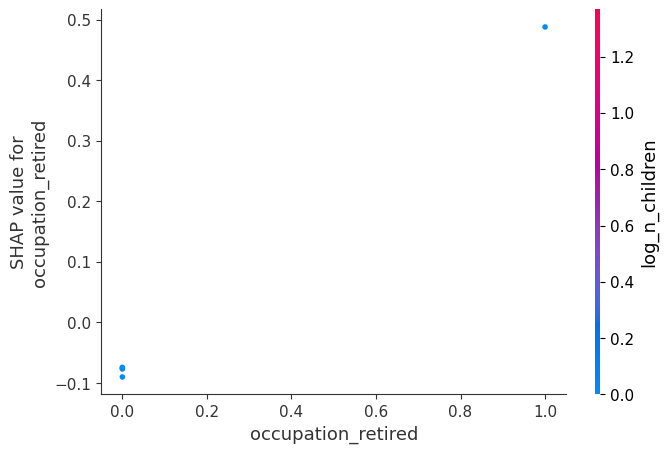

In [ ]:
import random
import shap
import numpy as np


# Summarize the background using shap.kmeans
K = 100  # Number of samples for summarization
background_data = shap.kmeans(X_train, K)  # Alternatively, use shap.sample(X_train, K)

# Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(lr_smote.predict_proba, background_data)

# Randomly select 5 instances from the test set
instance_indices = random.sample(range(len(X_test)), 5)
X_test_selected = X_test[instance_indices]

# Specify feature names explicitly
feature_names = feature_names

# Compute SHAP values for the selected instances
shap_values_all_classes = explainer.shap_values(X_test_selected)  # This returns a list (one per class)

# Select the class of interest (e.g., class 1 for "Approved")
class_of_interest = 1  # Adjust as needed
shap_values = shap_values_all_classes[:,:,class_of_interest]

# Debugging: Check the shape of the selected SHAP values
print("Shape of selected shap_values:", shap_values.shape)  # Should be (5, 48)

# Plot SHAP force plot for the 5 instances (for the selected class)
for idx in range(len(X_test_selected)):
    shap.force_plot(
        explainer.expected_value[class_of_interest],  # Expected value for the chosen class
        shap_values[idx],                             # SHAP values for the chosen class
        X_test_selected[idx],                         # Instance data
        feature_names=feature_names,                  # Feature names
        show=False
    )
plt.show()

# Plot SHAP dependence plot for the feature "occupation_retired"
feature_to_plot = 'occupation_retired'
shap.dependence_plot(
    feature_to_plot,
    shap_values,              # SHAP values for the chosen class
    X_test_selected,
    feature_names=feature_names  # Feature names
)

In [ ]:
# Choose an instance to explain (e.g., the first instance in the test set)
instance_index = 0
instance = X_test[instance_index]

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_test,
    mode="classification",
    feature_names=feature_names,  # Replace with your feature names list
    class_names=['Rejected', 'Approved'],  # Adjust based on your labels
    discretize_continuous=True
)

# Explain the prediction for the selected instance
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=lr_smote.predict_proba  # Use the model's probability prediction function
)

# Display the explanation
explanation.show_in_notebook()
# save as HTML file
explanation.save_to_file("lime_explanation.html")

In [ ]:
print(y_test.iloc[instance_index])

1


In [ ]:
probabilities = lr_smote.predict_proba(X_test[instance_index].reshape(1, -1))
classes = lr_smote.predict(X_test[instance_index].reshape(1, -1))
print(probabilities, classes)

[[0.40184454 0.59815546]] [1]
